## Pneumonia Identification using Chest XRays

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import numpy as np
import cv2
import pickle
from tqdm import tqdm

In [3]:
DATA_DIR = "/home/aneeshashmi/Desktop/Main/py/tf/Chest/ChestXRays/train"
CATEGORIES = ["NORMAL", "PNEUMONIA"]
IMG_SIZE_X = 400
IMG_SIZE_Y = 400

In [4]:
def show_img(image):
    plt.imshow(image, cmap = plt.cm.gray)
    print("size: ", image.shape)

### What original image looks like? 

size:  (1801, 2078)


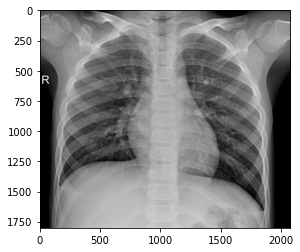

In [5]:
# loading an image
dir_addr = os.path.join(DATA_DIR, CATEGORIES[0])
imlst = os.listdir(dir_addr)

# images are RGB
im = cv2.imread(os.path.join(dir_addr, imlst[0])
               ,cv2.IMREAD_GRAYSCALE
               )
show_img(im)

### Resized Image

size:  (400, 400)


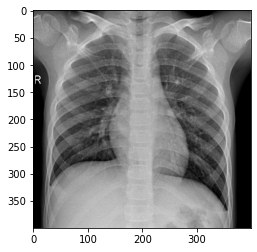

In [6]:
im_resized = cv2.resize(im, (IMG_SIZE_X, IMG_SIZE_Y))
show_img(im_resized)

### Load dataset
#### Try pickle or direct load and then save pickle

In [ ]:
def load_dataset_from_device(data_dir, pickefilename):
    print("loading data from dir...")
    dataset = []
    for (i, category) in enumerate(CATEGORIES):
        print(f'loading {category} ....')
        path = os.path.join(data_dir, category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (IMG_SIZE_X, IMG_SIZE_Y))
                img_array = img_array/255
                dataset.append((img_array, CATEGORIES.index(category)))                 
            except Exception as e:
               pass
#     save data for later use
    pickle.dump(dataset, open( pickefilename, "wb" ))
    return dataset

# try pickle and then load data
def load_dataset():
    try:
        dataset  = pickle.load(open("xrays_dataset.p", "rb"))
        print("loading model from pickle...")
    except Exception as e:
        dataset = load_dataset_from_device(DATA_DIR, "xrays_dataset.p")
    return dataset

dataset = load_dataset()

loading data from dir...
loading NORMAL ....
loading PNEUMONIA ....


### Shuffle loaded data and make image and label arrays

In [5]:
import random

def shuffle_dataset(dataset):
    random.shuffle(dataset)
    
    X = []
    y = []
    [[X.append(img), y.append(label)] for (img, label) in dataset]
    X = np.array(X).reshape(-1, IMG_SIZE_X, IMG_SIZE_Y, 1)
    y = np.array(y).reshape(-1,1)
    return (X, y)


(X,y, X_cv, y_cv) = shuffle_dataset(dataset)

In [6]:
X[0]

array([[[  0],
        [  0],
        [  0],
        ...,
        [125],
        [111],
        [109]],

       [[104],
        [107],
        [107],
        ...,
        [210],
        [212],
        [203]],

       [[191],
        [206],
        [204],
        ...,
        [177],
        [172],
        [166]],

       ...,

       [[204],
        [207],
        [203],
        ...,
        [207],
        [200],
        [201]],

       [[196],
        [194],
        [197],
        ...,
        [175],
        [172],
        [170]],

       [[174],
        [168],
        [168],
        ...,
        [  0],
        [  0],
        [  0]]], dtype=uint8)

## Model

In [6]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32,kernel_size=(4,4), activation = "relu", input_shape=(IMG_SIZE_X,IMG_SIZE_Y,1)) ,
        tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

        tf.keras.layers.Conv2D(filters=64,kernel_size=(4,4), activation = "relu") ,
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(), # size will be selected aumatically
        tf.keras.layers.Dense(64, activation = "relu"),
        tf.keras.layers.Dense(2, activation = "softmax"), # classifying two categories only
])

model.compile(
    optimizer="adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

### Load saved Model

In [8]:
# model = tf.keras.models.load_model("xrays_model")

### Let's train the model

In [8]:
model.fit(X,y, epochs = 1)
model.save("xrays_model")

164/164 [==============================] - 2253s 14s/step - loss: 75.2250 - accuracy: 0.7951: 2:31 - loss: 80.3627 - 
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: xrays_model/assets


### Testing model

In [9]:

test_data = load_dataset_from_device("/home/aneeshashmi/Desktop/Main/py/tf/Chest/ChestXRays/test", "xrays_testdataset.p")

In [10]:
(X_test,y_test) = shuffle_dataset(test_data)

In [ ]:
model.evaluate(X_test,y_test)
# model.weights

 6/20 [========>.....................] - ETA: 40s - loss: 1.3159 - accuracy: 0.3333

In [ ]:
model.fit(X,y, epochs = 1)
model.save("xrays_model")